# 16S rRNA Data Curation, Processing and Exploratory Analysis
This juptyer notebook goes through every step on how the 16S rRNA data used for training and testing the machine/deep learning models was obtained, curated, processed and visualised.

## Data Curation and Processing

The original full-length 16S rRNA sequences were obtained from the EzBio (61,827), GRD (12,939) and UDB (12,988) 16S databases. These were combined into 1 single dataset (87,754) which, after initial curation, resulted in a dataset of **70,785** entries.

This initial curation process consisted of:
- loading the csv files as a pandas data frame
- concatenating three data frames
- removing sequences that contain more than 1% ambiguous bases
- removing sequences that contain no taxonomic information at family, genus and species level
- unspecific taxon labels were replaced with NaN values

As this initial process was partially completed manually with excel (due to the inconsistent and evolving nature of the taxonomic nomenclature of prokaryotes), the step-by-step scripts in this jupyter notebook initialise with the combined dataset (full_curated_dataset.csv).

In order to distinguish incorrect or old taxon labels from correct ones, the List of Prokaryotic names with Standing in Nomenclature (LSPN) was used which can be accessed via this link: https://lpsn.dsmz.de/

The next few code cells contain some of the scripts that were used during the initial curation process, but they are not completely executable in this context.

In [41]:
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
seqs = SeqIO.parse('16S-UDb_sequences.fasta','fasta')
taxon_info = open('16S-UDb_MOTHUR_taxonomy.txt','r')
lines = taxon_info.readlines()

# Generate a matrix containing several lists that contain taxonomy information for each sequence id entry
# example: [[id1,kingdom,phylum,...,species], [id2,kingdom,phylum,...,species],...]
taxList = []
for line in lines:
    line = line.strip()
    id,semi_tax = line.split('\t')[0], line.split('\t')[1]
    taxs = semi_tax.split(';')
    id_tax_conc = []
    id_tax_conc.append(id)
    for tax in taxs:
        id_tax_conc.append(tax)
    taxList.append(id_tax_conc)

# Initiate seq_dict containing seq_id as a key and seq as a value
seq_dict = {}
for seq_record in seqs:
    seq_dict[seq_record.id] = str(seq_record.seq)

# Add sequence into the matrix
for tax in taxList:
    tax.append(seq_dict[tax[0]])

# Delete errors in species' name
result = []
for tax in taxList:
    if len(tax) == 9:
        result.append(tax)

# create Pandas dataframe 
taxon_column = ['ID', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'seq']
taxon_df = pd.DataFrame(data=result, columns=taxon_column)
taxon_df.head(5)

,ID,Kingdom,Phylum,Class,Order,Family,Genus,Species,seq
0,4321924,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,durum,GAGTTTGATCATGGCTCAGGACGAACGCTGGCGGCGTGCTTAACAC...
1,1042479,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,melaninogenica,GATGAACGCTAGCTATAGGCTTAACACATGCAAGTCGAGGGGAAAC...
2,557633,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Microbacteriaceae,Microbacterium,chocolatum,GATGAACGCTGGCGGCGTGCTTACACATGCAGTCTACCGGTGAAGC...
3,345899,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,copri,AGAGTTTGATTCTGGCTCAGGATGAACGCTAGCTACAGGCTTAACA...
4,299514,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,perfringens,AGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...


In [ ]:
# Script to combine (seprately curated) data frames
frames = [UDB, EZBIO, GRD]
tot_df = pd.concat(frames).reset_index()

#----------------------------------------------------------------------------------------------------------------------

# Returns True if a sequence contains more than a certain percantage of 'N' (ambiguous bases)
def too_much_N(sequence, percentage=0.01):
    sequence.count('N')/len(sequence) > percentage

#----------------------------------------------------------------------------------------------------------------------

# Returns the last word of string
def lastWord(string):
    # split by space and converting to list
    lis = list(string.split(" "))   
    # returning last element in list
    return lis[-1]                  

#----------------------------------------------------------------------------------------------------------------------

# Script to identify cells containing abnormal characters
bad_df = df[df.str.contains(r'[0-9!@#$%^&*()_+-=<>]')]

#----------------------------------------------------------------------------------------------------------------------

# Script to capitalize every taxon label from Kingdom to Genus
taxons = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence']
for taxon in taxons[:-2]:
    df[taxon] = df[taxon].str.capitalize()

#----------------------------------------------------------------------------------------------------------------------

# Script to remove chloroplast RNA
bad_df = df[df['Phylum'].str.contains('Chloroplast')]
df = df.drop(bad_df.index)

### 1. Deconverging the taxonomy
In order to train the RDP classifier without errors and retrieve meaningful results from the deep learning models, convergent evolution must be removed. The issue of converging evolution is demonstrated here:
- Bacteria / Verrucomicrobia / Verrucomicrobiae / Verrucomicrobiales / Verrucomicrobiaceae / Verrucomicrobium / Verrucomicrobium spinosum
- Bacteria / Verrucomicrobia / Verrucomicrobiae / Verrucomicrobiales / NaN                 / Verrucomicrobium / Verrucomicrobium alcali

The genus value (Verrucomicrobium) is equal for these two entries but the family label is missing for the second entry. The rules of taxonomic labelling do not allow this; **when a taxon for two organisms is equal, then all previous taxa in the taxonomic hierarchy must also be equal**.

But labelling every taxon is not always possible. When a sequence has not been identified at every taxonomic level or when a novel genus is identified, it may take a while before it is assigned to a specific family/class/order/... and this results in entires as shown below:
- Bacteria / Verrucomicrobia / Verrucomicrobiae / NaN / NaN / Verrucomicrobium / NaN
- Bacteria / Verrucomicrobia / Verrucomicrobiae / NaN / NaN / Verrucomicrobium / Verrucomicrobium spinosum

In order to remove NaN values from the dataset in a meaningful way, one can make use of the previous taxon labels.
- Bacteria / Verrucomicrobia / Verrucomicrobiae / c_Verrucomicrobiae / c_f_Verrucomicrobiae / Verrucomicrobium / Verrucomicrobium sp
- Bacteria / Verrucomicrobia / Verrucomicrobiae / c_Verrucomicrobiae / c_f_Verrucomicrobiae / Verrucomicrobium / Verrucomicrobium spinosum

In [42]:
import numpy as np, pandas as pd

In [43]:
df = pd.read_csv('full_curated_dataset.csv')

In [46]:
df_empty_filled = df.copy()
taxons = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
taxon_acronym = ['k_', 'p_', 'c_', 'o_', 'f_', 'g_', ' sp']

def empty_fill(df):
    df_empty_filled = df.copy()
    # enumerate over each column in the dataframe to automatically label the empty entries according to the aformentioned labelling
    for index, taxon in enumerate(taxons):
        
        # only at the species level, acryonym is added at the end
        if taxon == taxons[-1]:
            df_empty_filled[taxon][df_empty_filled[taxon].isna()] = df_empty_filled[taxons[index-1]] + taxon_acronym[index]
            
        else:
            df_empty_filled[taxon][df_empty_filled[taxon].isna()] = taxon_acronym[index] + df_empty_filled[taxons[index-1]]
    return df_empty_filled

df_empty_filled = empty_fill(df)
df_empty_filled.sample(10)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
33752,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,g_Oscillospiraceae,g_Oscillospiraceae sp,GACGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGGAGTC...
3082,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium deminutum,GTGCTTAACACATGCAAGTCGAACGGTGAAAGAGAGCTTGCTCTCT...
50498,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Kingella,Kingella kingae,GAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGGCGGCATG...
2108,Bacteria,Actinobacteria,Actinobacteria,Geodermatophilales,Geodermatophilaceae,Geodermatophilus,Geodermatophilus obscurus,ATCTACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGT...
49601,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,Acidovorax,Acidovorax ebreus,GAACTGTAGAGTTTGATCCTGGCTCAGATTGAACGCTGGCGGCATG...
8924,Bacteria,Actinobacteria,Thermoleophilia,Gaiellales,Gaiellaceae,Gaiella,Gaiella sp,GACGAACGCTGGCGGCGCGCTTAACACATGCAAGTCGAGCGAGAAC...
68397,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Spirochaetaceae,Treponema,Treponema sp,AACGAACGCTGGCGGCGCGTCTTAAGCATGCAAGTCGAGCGGCAGG...
36364,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Sporobacter,Sporobacter sp,GACGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGGGGTA...
11893,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella sp,GATGAACGCTAGCTACAGGCTTAACACATGCAAGTCGAGGGGCAGC...
619,Bacteria,Acidobacteria,Blastocatellia,Blastocatellales,Pyrinomonadaceae,g_Pyrinomonadaceae,g_Pyrinomonadaceae sp,ATTCAACGCTGGCGGCGTACTTCAAACATGCAAGTCGAACGCGAAA...


The original datasets sometimes contain a species label without a genus label (f.e. cereus), these are not NaN values and therefore ignored by the previous script. In order to standardise the dataset (Genus_name + species_name in species column) the following script was run.

In [47]:
# example of non-standard entry
df_empty_filled[df_empty_filled['Species'] == 'cereus'].head(3)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
21193,Bacteria,Firmicutes,Bacilli,Caryophanales,Bacillaceae,g_Bacillaceae,cereus,TTATTGGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTG...
21194,Bacteria,Firmicutes,Bacilli,Caryophanales,Bacillaceae,g_Bacillaceae,cereus,TTATTGGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTG...
21195,Bacteria,Firmicutes,Bacilli,Caryophanales,Bacillaceae,g_Bacillaceae,cereus,TTATTGGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTG...


In [48]:
not_sub_df = df_empty_filled[df_empty_filled['Species'].str.contains(' ')]
sub_df = df_empty_filled[~df_empty_filled['Species'].str.contains(' ')]


# edit species entry for species entry without genus information
sub_df['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']

# concatenate divided dataframes
frames = [not_sub_df, sub_df]
df_full = pd.concat(frames)

C:\Users\robbe\AppData\Local\Temp/ipykernel_8696/1583329882.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']


### 2. Removing ambiguous bases

In order to investigate how including ambiguous bases to the dataset effects the classification accuracy, a subset containing no ambiguous bases was created. 
To get an idea on how many of the entries contain ambiguous bases, a few simple comparisons were set up.

In [50]:
# dataframe without any ambiguous bases in the sequence column
df_non_ambiguous = df_full[~df_full['Sequence'].str.contains(r'[YRWSKMDVHBNX]')]

print(f"DF with ambiguous bases sequences: {df_full.shape}\n{df_full['Species'].value_counts()}\n\nDF without ambiguous bases sequences: {df_non_ambiguous.shape}\n{df_non_ambiguous['Species'].value_counts()}")

DF with ambiguous bases sequences: (70785, 8)
g_Oscillospiraceae sp         1238
g_Lachnospiraceae sp          1165
Escherichia coli               917
g_Planctomycetaceae sp         704
g_Christensenellaceae sp       666
                              ... 
Virgibacillus marismortui        1
Virgibacillus natechei           1
Virgibacillus ndiopensis         1
Virgibacillus olivae             1
g_Mycoplasmataceae zalophi       1
Name: Species, Length: 18193, dtype: int64

DF without ambiguous bases sequences: (65235, 8)
g_Oscillospiraceae sp            1141
g_Lachnospiraceae sp             1077
Escherichia coli                  904
g_Planctomycetaceae sp            635
g_Christensenellaceae sp          614
                                 ... 
Oceanobacillus locisalsi            1
Oceanobacillus longus               1
Oceanobacillus manasiensis          1
Oceanobacillus massiliensis         1
g_Mycoplasmataceae verecundum       1
Name: Species, Length: 16666, dtype: int64


### 3. Setting up a minimum number of entries

As the deep learning models split the data into a training/validation/test set, a minimum of 5 and preferably 10 representatives for a specific label are required in order to ensure each stratum contains at least 1 or 2 sequences of each unique taxon.

In [51]:
# demanding a minimum of 10 representatives at the species level
def min_entries(df, taxon='Species', min=10):
    return df[df[taxon].map(df[taxon].value_counts()) > min]

# with ambiguous bases
df_min = min_entries(df_full)

# without ambiguous bases
df_non_amb_min = min_entries(df_non_ambiguous)

In [12]:
# reduction in the amount of entries and unique species
print(f"ENTRIES | UNIQUE SPECIES\n\n  {len(df_full)} | {df_full['Species'].nunique()}  - without data restrictions\n  {len(df_non_ambiguous)} | {df_non_ambiguous['Species'].nunique()}  - after no-ambiguity restriction\n  {len(df_min)} | {df_min['Species'].nunique()}    - after minimal-species restriction\n  {len(df_non_amb_min)} | {df_non_amb_min['Species'].nunique()}    - after no-ambiguity AND minimal species restriction\n\n {round((len(df_full)-len(df_non_amb_min))/len(df_full), 4)} | {round((df_full['Species'].nunique()-df_non_amb_min['Species'].nunique())/df_full['Species'].nunique(), 4)} - % representation-loss with both restrictions\n                   (no ambiguous bases and minimal amount of entries at species level")

ENTRIES | UNIQUE SPECIES

  70785 | 18193  - without data restrictions
  65235 | 16666  - after no-ambiguity restriction
  39154 | 826    - after minimal-species restriction
  36436 | 786    - after no-ambiguity AND minimal species restriction

 0.4853 | 0.9568 - % representation-loss with both restrictions
                   (no ambiguous bases and minimal amount of entries at species level


The value counts clearly indicate that setting up these strict requirements (no ambiguity and minimal representatives) is not a great option; the amount of entries and the diversity of species are reduced very dramatically.

Noticeable is that the effect of the removal of ambiguous bases in small compared to the effect of a minimal-species-entry requirement

### 4. Setting up a maximum number of entries requirement

In order to generate a well-balances dataset, over-representation of certain labels must be restricted. One could do this by collapsing sequences of the same label to generate an average nucleotide sequence, preferably without any ambiguous bases.

As a temporary and quick fix, this script removes entries containing ambiguous bases in its sequence dependent on how over-represented the label is. This part of the data processing needs further looking into in order to generate a more well-balanced dataset in a better and cleaner way.

In [52]:
def ambiguity(seq):
    counter = seq.count('Y')+seq.count('R')+seq.count('W')+seq.count('S')+seq.count('K')+seq.count('M')+seq.count('D')+seq.count('V')+seq.count('H')+seq.count('B')+seq.count('N')+seq.count('X')
    return counter/len(seq)

def remove_over_repr_ambiguous(df, taxon='Species', min=10, cruelty=4):
    # values and arrays used for distinguishing and choosing over/under-represented labels
    ultra_bool = np.full(len(df), True)
    lookup_ambiguity = (df['Sequence'].apply(lambda seq : ambiguity(seq))).to_numpy()

    # ambiguity and over/under-representation is checked for each unique label
    unique_labels = df[taxon].unique()
    for label in unique_labels:
        label_count = df[taxon].value_counts()[label]
        ultra_bool = ultra_bool & ((lookup_ambiguity < ((1/(label_count/min)) ** cruelty)) | (df[taxon] != label).to_numpy())

    # subsetting the desired rows with a boolean array
    # (everything except for the ambiguos sequences of over-represented labels)
    return df[ultra_bool]

In [115]:
# verifying the result
print(df_min.shape)

df_min_max = remove_over_repr_ambiguous(df_min)
print(df_min_max.shape)

(39154, 8)
(37703, 8)


In [121]:
print(f"Value counts for species with only min. restriction:\n{df_min['Species'].value_counts()}\n\nValue counts for species with min. and max. restriction:\n{df_min_max['Species'].value_counts()}")

Value counts for species with only min. restriction:
g_Oscillospiraceae sp       1238
g_Lachnospiraceae sp        1165
Escherichia coli             917
g_Planctomycetaceae sp       704
g_Christensenellaceae sp     666
                            ... 
Thermoanaerobacter sp         11
Prevotella nanceiensis        11
Prevotella tannerae           11
Vibrio furnissii              11
Staphylococcus warneri        11
Name: Species, Length: 826, dtype: int64

Value counts for species with min. and max. restriction:
g_Oscillospiraceae sp       1141
g_Lachnospiraceae sp        1077
Escherichia coli             904
g_Planctomycetaceae sp       635
g_Christensenellaceae sp     614
                            ... 
Thermoanaerobacter sp         11
Prevotella nanceiensis        11
Prevotella tannerae           11
Vibrio furnissii              11
Staphylococcus warneri        11
Name: Species, Length: 826, dtype: int64


The change is not very significant, (as there are few sequences with ambiguous bases) but the function does deliver the desired result: loss of entries for overrepresented labels and no loss of entries for underrepresented labels.

In [114]:
# instances of E. coli
print(df_min['Species'].value_counts()['Escherichia coli'])
print(df_min_max['Species'].value_counts()['Escherichia coli'])

917
904


### 5. Reverse complement sequences

Knowing that DNA sequences show complementarity, the reverse complement sequence should give rise to the same classification result. In order to better represent this biological property and increase the number of entries in the dataset (for underrepresented labels), the reverse complement sequences were added.

In [58]:
# returns a reverse complement DNA sequence
complement_dict = {'A': 'T', 'C': 'G', 'T': 'A', 'G': 'C', 'U':'A', 'Y':'R', 'R':'Y', 'W':'W', 'S':'S', 'K':'M', 'M':'K', 'D':'H', 'V':'B', 'H':'D', 'B':'V', 'N':'N', 'X':'X'}
def reverse_complement(seq):
    seq_list = list(seq)
    seq_list = [complement_dict[base] for base in seq_list]
    return ''.join(seq_list)[::-1]

# applies the previous function only to under represented labels
def representative_rc(df, taxon='Genus'):
    # values and arrays used for distinguishing and choosing over/under-represented labels
    label_avg = df[taxon].value_counts().mean()
    label_min = df[taxon].value_counts().min()
    label_max = df[taxon].value_counts().max()
    rand_series = np.random.uniform(low=label_min, high=label_max, size=len(df))
    ultra_bool = np.full(len(df), True)

    # over/under-representation is checked for each unique label
    unique_labels = df[taxon].unique()
    for label in unique_labels:
        label_count = df[taxon].value_counts()[label]
        ultra_bool = ultra_bool & (((rand_series + ((label_count**2)/label_avg)) < label_max) | (df[taxon] != label))

    # subsetting the desired rows (under-represented labels) with a boolean array
    # and generating the reverse sequence
    df = df[ultra_bool]
    df['Sequence'] = df['Sequence'].apply(lambda row : reverse_complement(row))
    return df

In [59]:
rc_df = representative_rc(df_full)
# the original and reverse complement datasets are combined
df_full_with_rc = pd.concat([df_full, rc_df], ignore_index=True)
print(df_full.shape, df_full_with_rc.shape)

(70785, 8) (105049, 8)


C:\Users\robbe\AppData\Local\Temp/ipykernel_8696/4038198815.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sequence'] = df['Sequence'].apply(lambda row : reverse_complement(row))


In [120]:
print(f"Value counts for genera before adding reverse complement sequences:\n{df_full['Genus'].value_counts()}\n\nValue counts for genera after adding reverse complement sequences:\n{df_full_with_rc['Genus'].value_counts()}")

Value counts for genera before adding reverse complement sequences:
Bacillus               1272
g_Oscillospiraceae     1249
g_Lachnospiraceae      1205
Streptococcus          1136
Streptomyces           1043
                       ... 
Huakuichenia              1
g_Motilibacteraceae       1
Tunicatimonas             1
Hugenholtzia              1
Ascidianibacter           1
Name: Genus, Length: 3337, dtype: int64

Value counts for genera after adding reverse complement sequences:
Bacillus              1272
g_Oscillospiraceae    1249
g_Lachnospiraceae     1205
Streptococcus         1136
Streptomyces          1043
                      ... 
Marinithermofilum        2
Marinagarivorans         2
Marinibactrum            2
Hazenella                2
Allostreptomyces         2
Name: Genus, Length: 3337, dtype: int64


The function effectively generates reverse complement entries only for under-represented labels.

### 6. Adding the sequence ID column
To utilise curated sequence data in various models, a sequence id column is added for each entry.

In [60]:
def add_SeqID(df):
    seq_id_list = []
    df_size = len(df)
    fill = len(str(df_size))

    # generating list of Sequence IDs
    for i in range(df_size):
        seq_id_list.append('seq_id' + str(i).zfill(fill))

    df.insert(0, 'Seq_id', seq_id_list)
    return df

In [61]:
df_full_with_rc_id = add_SeqID(df_full_with_rc)
df_full_with_rc_id.head()

,Seq_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
0,seq_id000000,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,ACATGCAAGTCGCACGAGAAAGTGGGAGCAATCCCATGAGTACAGT...
1,seq_id000001,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAGAAAGTGG...
2,seq_id000002,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAGAAAGTGG...
3,seq_id000003,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGTACGAGAAAGTGG...
4,seq_id000004,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAGAAAGGGG...


### 7. Generating subsets and unique taxon sets
To examine the impact of using only a single taxon instead of the full hierarchy and/or a minimal amount of representatives for a specific taxon, various subsets of the dataset were created.

In [62]:
# generate dataset with a minimum of 10 sequeces for each unique spcies

# from the data frame without reverse complement sequences 
df_min_spe = min_entries(df_full)
# from the data frame containing reverse complement sequences 
df_min_spe_rc = min_entries(df_full_with_rc)

After adding reverse complement sequences, many species are no longer excluded when a minimum of 10 sequences is required for each unique species label. This also demostrates that the dataset contains many species for which there are only a few sequences.

In [125]:
# Reduction in the amount of entries and unique species
print(f"Number of entries and unique species without adding reverse complement sequences and without restrictions\n({len(df_full)}, {df_full['Species'].nunique()})\n")
print(f"ENTRIES | UNIQUE SPECIES (after minimum-species restriction)\n  {len(df_min_spe)} | {df_min_spe['Species'].nunique()}    - without adding reverse complement sequences\n  {len(df_min_spe_rc)} | {df_min_spe_rc['Species'].nunique()}   - with reverse complement sequences\n\n {round((len(df_full)-len(df_min_spe))/len(df_full), 4)} | {round((df_full['Species'].nunique()-df_min_spe['Species'].nunique())/df_full['Species'].nunique(), 4)} - % representation-loss without reverse complement\n {round((len(df_full)-len(df_min_spe_rc))/len(df_full), 4)} | {round((df_full['Species'].nunique()-df_min_spe_rc['Species'].nunique())/df_full['Species'].nunique(), 4)} - % representation-loss with reverse complement")

Number of entries and unique species without adding reverse complement sequences and without restrictions
(70785, 18193)

ENTRIES | UNIQUE SPECIES (after minimum-species restriction)
  39154 | 826    - without adding reverse complement sequences
  59642 | 1344   - with reverse complement sequences

 0.4469 | 0.9546 - % representation-loss without reverse complement
 0.1574 | 0.9261 - % representation-loss with reverse complement


The following code was used to list all unique taxon labels and subset the dataset per taxon.

In [63]:
# Finding all unique taxons
def lst_unique_taxons(df, taxon='Genus'):
    return list(df[taxon].dropna().unique())

unique_genera = lst_unique_taxons(df_min_spe_rc)
print(f"The number of unique Genera: {len(unique_genera)}")

# Subsetting per taxon
def subset_taxons(df, taxons=['Genus']):
    taxons.append('Seq_id', 'Sequence')
    new_df = df[taxons].dropna()

# fe:   df = pd.read_csv('filename.csv')
#       new_df = subset_taxons(df, taxon = ['Family', 'Genus', 'Species'])
#       new_df.to_csv('new_name.csv', index = False)

The number of unique Genera: 952


### Putting it all together - For data visualization

What follows is a script to generate and save the desired dataset.

In [128]:
# ---------------------------------------------------------------------------------------------------
# Loading the dataset as a pandas data frame --------------------------------------------------------
df = pd.read_csv('full_curated_dataset.csv')
print(f"dataset loaded, shape: {df.shape}")

# ---------------------------------------------------------------------------------------------------
# Labeling empty cells with an informative value ----------------------------------------------------
df_empty_filled = empty_fill(df)

# ---------------------------------------------------------------------------------------------------
# Standardizing the species columns -----------------------------------------------------------------
not_sub_df = df_empty_filled[df_empty_filled['Species'].str.contains(' ')]
sub_df = df_empty_filled[~df_empty_filled['Species'].str.contains(' ')]

#       edit species entry for species entry without genus information
sub_df['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']

#       concatenate divided dataframes
frames = [not_sub_df, sub_df]
df_full = pd.concat(frames)
print(f"dataset filled and standardized, shape: {df_full.shape}")

# ---------------------------------------------------------------------------------------------------
# Tackle overrepresentation with nucleotide ambiguity -----------------------------------------------
df_full_temp = min_entries(df_full, min=5)
#       min_entries line was added to reduce runtime
#       -> partial un-underrepresentation but without consequences
#          for saving species diversity after reverse complement step
df_full_max = remove_over_repr_ambiguous(df_full_temp)
print(f"dataset un-overrepresented, shape: {df_full_max.shape}")

# ---------------------------------------------------------------------------------------------------
# Increase the amount of entries by adding the reverse complement sequences -------------------------
rc_df = representative_rc(df_full_max)
#       the original and reverse complement datasets are combined, effectively doubling the dataset
df_full_max_rc = pd.concat([df_full_max, rc_df], ignore_index=True)
print(f"dataset reverse complemented, shape: {df_full_max_rc.shape}")

# ---------------------------------------------------------------------------------------------------
# Tackle underrepresentation by setting a minimum number of entries ---------------------------------
df_full_min_max_rc = min_entries(df_full_max_rc, min=10)
print(f"dataset un-underrepresented, shape: {df_full_min_max_rc.shape}")

# ---------------------------------------------------------------------------------------------------
# Add sequence ID -----------------------------------------------------------------------------------
df_full_min_max_rc_id = add_SeqID(df_full_min_max_rc)
df_full_min_max_rc_id.to_csv('df_full_min_max_rc_id.csv')
print(f"dataset saved, shape: {df_full_min_max_rc.shape}")

dataset loaded, shape: (70785, 8)
dataset filled and standardized, shape: (70785, 8)


C:\Users\robbe\AppData\Local\Temp/ipykernel_12772/3340266006.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']


dataset un-overrepresented, shape: (43319, 8)
dataset reverse complemented, shape: (65098, 8)
dataset un-underrepresented, shape: (63945, 8)
dataset saved, shape: (63945, 9)


C:\Users\robbe\AppData\Local\Temp/ipykernel_12772/4038198815.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sequence'] = df['Sequence'].apply(lambda row : reverse_complement(row))


In [131]:
# these two datasets will be compared in the next section
df_full.to_csv('df_0.csv', index=False)
df_full_min_max_rc.to_csv('df_1.csv', index=False)

## Exploratory Data Analysis

To analyse the curated 16S rRNA sequence dataset and summarise its features, visualisations including frequency bar charts and pie charts are genreated.

As the classification task with deep learning models is implemented at an individual taxon level (i.e. Family, Genus and Species), the visuals are created for each taxon level to identify its distribution and the extent of over- or under-representation. In this case, Python library **seaborn** is used to create plots.

To get an initial idea of plots, the website python graph gallery shows a variety of visuals that can be plotted with python libraries such as Matplotlib, Seaborn and Plotly and it can be accessed via this link: https://python-graph-gallery.com/.

For each taxon hierarchy level, namely, phylum, class, order, family, genus and species, the followings are shown.
- Dataframe with count and represented percentage for each label
- Bar chart containing top 10 over-represented labels with average count across all labels
- Bar chart containing top 10 over-represented labels with average count across all labels after removing species with less than 10 sequences

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_full = pd.read_csv('df_0.csv')
df_full_min_max_rc = pd.read_csv('df_1.csv')

In [9]:
sns.set_style("dark")
sns.set_theme()

### 1. Phylum

In [18]:
# phylum % representation dataframe with average
phylum_df = pd.DataFrame(df_full.Phylum.value_counts().reset_index().values, columns=["Phylum", "Count"])
phylum_df['Represented %'] = phylum_df['Count']/phylum_df['Count'].sum() * 100
phylum_df['Represented %'] = phylum_df['Represented %'].astype(float).round(2)
phylum_count_df = phylum_df.set_index('Phylum')

phylum_head_df = phylum_df.head(4)
phylum_others_df = phylum_df.iloc[4: , :]

# calculate average count and average represented percentage for the entire column - label count of phylum
phylum_avg = phylum_df['Count'].mean().astype(int).round(0)
phylum_avg_pct = phylum_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with phylum dataframe 
phylum_avg = pd.DataFrame({'Phylum':['AVERAGE'], 'Count':[phylum_avg], 'Represented %':[phylum_avg_pct]})
frames = [phylum_avg, phylum_df]
phylum_df_with_avg=pd.concat(frames)

# show first 10 labels in phylum including average count value for phylum
phylum_df_with_avg.set_index('Phylum').head(10)

,Count,Represented %
Phylum,,
AVERAGE,1573,2.22
Proteobacteria,25272,35.70
Firmicutes,18418,26.02
Bacteroidetes,8469,11.96
Actinobacteria,8104,11.45
Planctomycetes,2007,2.84
Spirochaetes,1363,1.93
Acidobacteria,1027,1.45
Cyanobacteria,888,1.25


In [19]:
#--------After minimum requirement--------
# phylum % representation dataframe with average
phylum_df = pd.DataFrame(df_full_min_max_rc.Phylum.value_counts().reset_index().values, columns=["Phylum", "Count"])
phylum_df['Represented %'] = phylum_df['Count']/phylum_df['Count'].sum() * 100
phylum_df['Represented %'] = phylum_df['Represented %'].astype(float).round(2)
phylum_count_df = phylum_df.set_index('Phylum')

phylum_head_df = phylum_df.head(4)
phylum_others_df = phylum_df.iloc[4: , :]

# calculate average count and average represented percentage for the entire column - label count of phylum
phylum_avg = phylum_df['Count'].mean().astype(int).round(0)
phylum_avg_pct = phylum_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with phylum dataframe 
phylum_avg = pd.DataFrame({'Phylum':['AVERAGE'], 'Count':[phylum_avg], 'Represented %':[phylum_avg_pct]})
frames = [phylum_avg, phylum_df]
phylum_df_with_avg=pd.concat(frames)

# show first 10 labels in phylum including average count value for phylum
phylum_df_with_avg.set_index('Phylum').head(10)

,Count,Represented %
Phylum,,
AVERAGE,1827,2.86
Proteobacteria,22933,35.86
Firmicutes,16729,26.16
Bacteroidetes,7712,12.06
Actinobacteria,4696,7.34
Planctomycetes,2253,3.52
Acidobacteria,1415,2.21
Spirochaetes,1356,2.12
Verrucomicrobia,1183,1.85


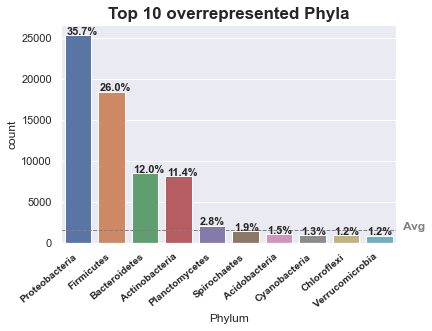

In [146]:
# top 10 Phylum and its frequency in a bar chart 
ax = sns.countplot(x='Phylum', data=df_full, order=df_full.Phylum.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Phyla', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(phylum_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, phylum_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full.Phylum))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+100), size = 11, weight='bold')

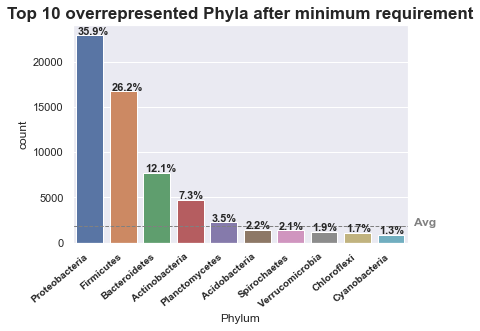

In [148]:
# top 10 Phylum and its frequency in a bar chart 
ax = sns.countplot(x='Phylum', data=df_full_min_max_rc, order=df_full_min_max_rc.Phylum.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Phyla after minimum requirement', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(phylum_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, phylum_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full_min_max_rc.Phylum))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+100), size = 11, weight='bold')

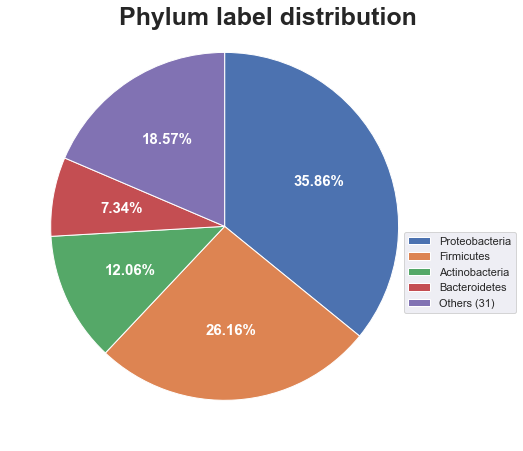

In [20]:
phylum_other_sum = phylum_others_df['Count'].sum()
pct_value = round(phylum_other_sum/phylum_df['Count'].sum() * 100, 2)
phylum_others_df=pd.DataFrame({'Phylum':['Others'], 'Count':[phylum_other_sum], 'represented %':[pct_value]})
frames = [phylum_head_df, phylum_others_df]
phylum_pie_df=pd.concat(frames)

num_phylum=len(phylum_df['Phylum'].unique())-4
labels = phylum_pie_df['Phylum'].to_list()
frequency =  phylum_pie_df['Count'].to_list()
 
fig = plt.figure(figsize=(8,8)) 
fig.set_facecolor('white')
ax = fig.add_subplot() 
 
pie = ax.pie(frequency, 
       startangle=90, 
       counterclock=False, 
       autopct=lambda p : '{:.2f}%'.format(p))

plt.setp(pie[2], size=15, weight="bold", color='white')
plt.title('Phylum label distribution', size=25, weight='bold', x=0.6, y=0.95)
plt.legend(pie[0],['Proteobacteria', 'Firmicutes', 'Actinobacteria', 'Bacteroidetes', 'Others ({})'.format(num_phylum)], bbox_to_anchor=(0.9,0.5))

At phylum level, a majority of the dataset is labelled as Proteobacteria and Firmicutes, representing more than 60% as illustrated by a dataframe with count values, bar chart and pie chart. This demonstrates the overrepresentation of Proteobacteria and Firmicutes, as the average representation percentage of phylum labels is only 2.2%. By comparing bar charts before and after removing species labels containing less than 10 entries, an increase in the average phylum count is shown as a horizontal line in the chart.

### 2. Class

In [10]:
# class % representation dataframe with average
class_df = pd.DataFrame(df_full.Class.value_counts().reset_index().values, columns=["Class", "Count"])
class_df['Represented %'] = class_df['Count']/class_df['Count'].sum() * 100
class_df['Represented %'] = class_df['Represented %'].astype(float).round(2)
class_count_df = class_df.set_index('Class')

class_head_df = class_df.head(8)
class_others_df = class_df.iloc[8: , :]

# calculate average count and average represented percentage for the entire column - label count of class
class_avg = class_df['Count'].mean().astype(int).round(0)
class_avg_pct = class_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with class dataframe 
class_avg = pd.DataFrame({'Class':['AVERAGE'], 'Count':[class_avg], 'Represented %':[class_avg_pct]})
frames = [class_avg, class_df]
class_df_with_avg=pd.concat(frames)

# show first 10 labels in class including average count value for class
class_df_with_avg.set_index('Class').head(10)

,Count,Represented %
Class,,
AVERAGE,700,0.99
Gammaproteobacteria,11777,16.64
Clostridia,8785,12.41
Bacilli,8491,12.00
Actinobacteria,7009,9.90
Alphaproteobacteria,6429,9.08
Bacteroidia,3325,4.70
Betaproteobacteria,2870,4.05
Deltaproteobacteria,2568,3.63


In [14]:
#--------After minimum requirement--------
# class % representation dataframe with average
class_df = pd.DataFrame(df_full_min_max_rc.Class.value_counts().reset_index().values, columns=["Class", "Count"])
class_df['Represented %'] = class_df['Count']/class_df['Count'].sum() * 100
class_df['Represented %'] = class_df['Represented %'].astype(float).round(2)
class_count_df = class_df.set_index('Class')

class_head_df = class_df.head(8)
class_others_df = class_df.iloc[8: , :]

# calculate average count and average represented percentage for the entire column - label count of class
class_avg = class_df['Count'].mean().astype(int).round(0)
class_avg_pct = class_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with class dataframe 
class_avg = pd.DataFrame({'Class':['AVERAGE'], 'Count':[class_avg], 'Represented %':[class_avg_pct]})
frames = [class_avg, class_df]
class_df_with_avg=pd.concat(frames)

# show first 10 labels in class including average count value for class
class_df_with_avg.set_index('Class').head(10)

,Count,Represented %
Class,,
AVERAGE,779,1.22
Gammaproteobacteria,10570,16.53
Clostridia,9047,14.15
Bacilli,6223,9.73
Alphaproteobacteria,4984,7.79
Bacteroidia,3734,5.84
Deltaproteobacteria,3158,4.94
Actinobacteria,3101,4.85
Betaproteobacteria,2206,3.45


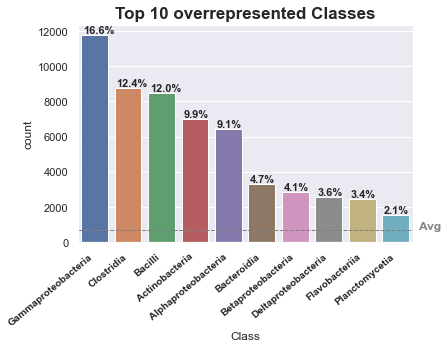

In [11]:
# top 10 Class and its frequency in a bar chart 
ax = sns.countplot(x='Class', data=df_full, order=df_full.Class.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Classes', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(class_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, class_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full.Class))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+100), size = 11, weight='bold')

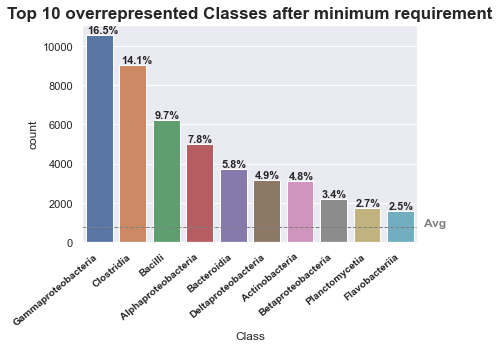

In [16]:
# top 10 Class and its frequency in a bar chart 
ax = sns.countplot(x='Class', data=df_full_min_max_rc, order=df_full_min_max_rc.Class.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Classes after minimum requirement', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(class_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, class_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full_min_max_rc.Class))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+100), size = 11, weight='bold')

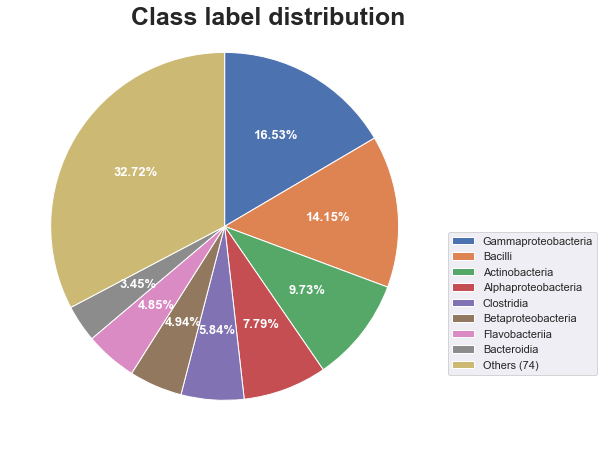

In [21]:
class_other_sum = class_others_df['Count'].sum()
pct_value = round(class_other_sum/phylum_df['Count'].sum() * 100, 2)
class_others_df=pd.DataFrame({'Class':['Others'], 'Count':[class_other_sum], 'represented %':[pct_value]})
frames = [class_head_df, class_others_df]
class_pie_df=pd.concat(frames)
 
num_class=len(class_df['Class'].unique())-8
labels = class_pie_df['Class'].to_list()
frequency =  class_pie_df['Count'].to_list()
 
fig = plt.figure(figsize=(8,8)) 
fig.set_facecolor('white')
ax = fig.add_subplot() 
 
pie = ax.pie(frequency, 
       startangle=90, 
       counterclock=False, 
       autopct=lambda p : '{:.2f}%'.format(p))

plt.setp(pie[2], size=13, weight="bold", color='white')
plt.title('Class label distribution', size=25, weight='bold', x=0.6, y=0.95)
plt.legend(pie[0],['Gammaproteobacteria',
 'Bacilli',
 'Actinobacteria',
 'Alphaproteobacteria',
 'Clostridia',
 'Betaproteobacteria',
 'Flavobacteriia',
 'Bacteroidia',
 'Others ({})'.format(num_class)], loc='best', bbox_to_anchor=(1,0.5))

At class level, approximately 30% of dataset has labels Gammaproteobacteria and Bacilli. The extent of over-representation of top taxa is already lower than the earlier taxonomy hierarchy. Similar to the phylum level, the average count of the entire label is increased after imposing a minimum requirement of 10 sequences at species level.

### 3. Order

In [22]:
# order % representation dataframe with average
order_df = pd.DataFrame(df_full.Order.value_counts().reset_index().values, columns=["Order", "Count"])
order_df['Represented %'] = order_df['Count']/order_df['Count'].sum() * 100
order_df['Represented %'] = order_df['Represented %'].astype(float).round(2)
order_count_df = order_df.set_index('Order')

# calculate average count and average represented percentage for the entire column - label count of order
order_avg = order_df['Count'].mean().astype(int).round(0)
order_avg_pct = order_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with order dataframe 
order_avg = pd.DataFrame({'Order':['AVERAGE'], 'Count':[order_avg], 'Represented %':[order_avg_pct]})
frames = [order_avg, order_df]
order_df_with_avg=pd.concat(frames)

# show first 10 labels in class including average count value for order
order_df_with_avg.set_index('Order').head(10)

,Count,Represented %
Order,,
AVERAGE,306,0.43
Eubacteriales,8409,11.88
Caryophanales,5517,7.79
Enterobacterales,3452,4.88
Bacteroidales,3309,4.67
Lactobacillales,2974,4.20
Flavobacteriales,2423,3.42
Hyphomicrobiales,2048,2.89
Burkholderiales,1817,2.57


In [24]:
#--------After minimum requirement--------
# order % representation dataframe with average
order_df = pd.DataFrame(df_full_min_max_rc.Order.value_counts().reset_index().values, columns=["Order", "Count"])
order_df['Represented %'] = order_df['Count']/order_df['Count'].sum() * 100
order_df['Represented %'] = order_df['Represented %'].astype(float).round(2)
order_count_df = order_df.set_index('Order')

# calculate average count and average represented percentage for the entire column - label count of order
order_avg = order_df['Count'].mean().astype(int).round(0)
order_avg_pct = order_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with order dataframe 
order_avg = pd.DataFrame({'Order':['AVERAGE'], 'Count':[order_avg], 'Represented %':[order_avg_pct]})
frames = [order_avg, order_df]
order_df_with_avg=pd.concat(frames)

# show first 10 labels in class including average count value for order
order_df_with_avg.set_index('Order').head(10)

,Count,Represented %
Order,,
AVERAGE,369,0.58
Eubacteriales,8732,13.66
Caryophanales,3910,6.11
Enterobacterales,3812,5.96
Bacteroidales,3704,5.79
Lactobacillales,2313,3.62
Hyphomicrobiales,1573,2.46
Flavobacteriales,1567,2.45
Rhodospirillales,1284,2.01


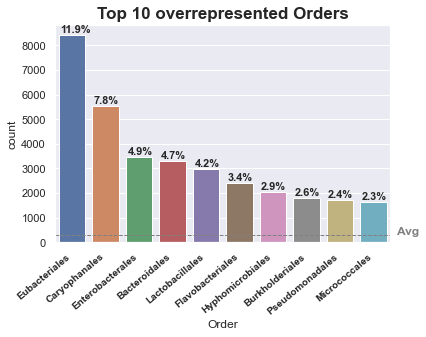

In [23]:
# top 10 Order and its frequency in a bar chart 
ax = sns.countplot(x='Order', data=df_full, order=df_full.Order.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Orders', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(order_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, order_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full.Order))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+100), size = 11, weight='bold')

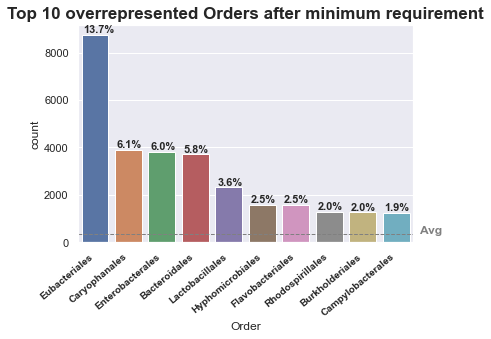

In [25]:
# top 10 Order and its frequency in a bar chart 
ax = sns.countplot(x='Order', data=df_full_min_max_rc, order=df_full_min_max_rc.Order.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Orders after minimum requirement', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(order_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, order_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full_min_max_rc.Order))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+100), size = 11, weight='bold')

The most over-represented order label is Eubacteriales, which represents around 14% of the dataset after the minimum requirement. It is clear from the order level that the extent of over-representation is much smaller as we go down through the taxonomy hierarchy.

### 4. Family

In [26]:
# family % representation dataframe with average
family_df = pd.DataFrame(df_full.Family.value_counts().reset_index().values, columns=["Family", "Count"])
family_df['Represented %'] = family_df['Count']/family_df['Count'].sum() * 100
family_df['Represented %'] = family_df['Represented %'].astype(float).round(2)
family_count_df = family_df.set_index('Family')

# calculate average count and average represented percentage for the entire column - label count of family
family_avg = family_df['Count'].mean().astype(int).round(0)
family_avg_pct = family_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with family dataframe 
family_avg = pd.DataFrame({'Family':['AVERAGE'], 'Count':[family_avg], 'Represented %':[family_avg_pct]})
frames = [family_avg, family_df]
family_df_with_avg = pd.concat(frames)

# show first 10 labels in family including average count value for family
family_df_with_avg.set_index('Family').head(10)

,Count,Represented %
Family,,
AVERAGE,132,0.19
Bacillaceae,2933,4.14
Oscillospiraceae,2924,4.13
Enterobacteriaceae,2147,3.03
Flavobacteriaceae,2136,3.02
Lachnospiraceae,2082,2.94
Streptococcaceae,1251,1.77
Rhodobacteraceae,1206,1.70
Spirochaetaceae,1156,1.63


In [29]:
#--------After minimum requirement--------
# family % representation dataframe with average
family_df = pd.DataFrame(df_full_min_max_rc.Family.value_counts().reset_index().values, columns=["Family", "Count"])
family_df['Represented %'] = family_df['Count']/family_df['Count'].sum() * 100
family_df['Represented %'] = family_df['Represented %'].astype(float).round(2)
family_count_df = family_df.set_index('Family')

# calculate average count and average represented percentage for the entire column - label count of family
family_avg = family_df['Count'].mean().astype(int).round(0)
family_avg_pct = family_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with family dataframe 
family_avg = pd.DataFrame({'Family':['AVERAGE'], 'Count':[family_avg], 'Represented %':[family_avg_pct]})
frames = [family_avg, family_df]
family_df_with_avg = pd.concat(frames)

# show first 10 labels in family including average count value for family
family_df_with_avg.set_index('Family').head(10)

,Count,Represented %
Family,,
AVERAGE,183,0.29
Oscillospiraceae,3074,4.81
Lachnospiraceae,2244,3.51
Enterobacteriaceae,2229,3.49
Bacillaceae,2122,3.32
Flavobacteriaceae,1183,1.85
Spirochaetaceae,1094,1.71
Streptococcaceae,1082,1.69
Porphyromonadaceae,950,1.49


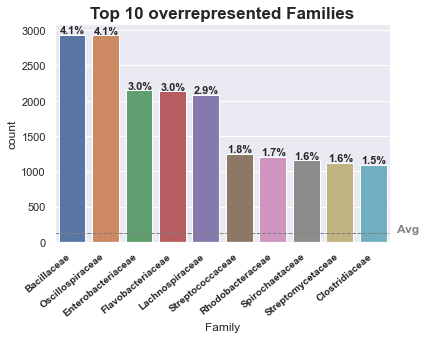

In [27]:
# top 10 Family and its frequency in a bar chart 
ax = sns.countplot(x='Family', data=df_full, order=df_full.Family.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Families', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(family_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, family_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full.Family))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+20), size = 11, weight='bold')

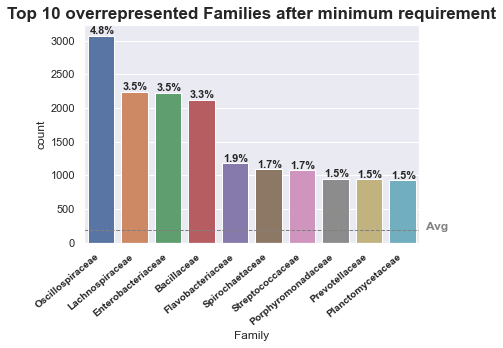

In [30]:
# top 10 Family and its frequency in a bar chart 
ax = sns.countplot(x='Family', data=df_full_min_max_rc, order=df_full_min_max_rc.Family.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Families after minimum requirement', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(family_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, family_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full_min_max_rc.Family))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+20), size = 11, weight='bold')

At family level, which is the hierarchy level at which the classification task begins, Oscillospiraceae is the most abundant family label, having around 3000 counts. The difference of the represented percentage between Oscillospiraceae and the average value is not as substantial compared to the phylum level.

### 5. Genus

In [31]:
# genus % representation dataframe with average
genus_df = pd.DataFrame(df_full.Genus.value_counts().reset_index().values, columns=["Genus", "Count"])
genus_df['Represented %'] = genus_df['Count']/genus_df['Count'].sum() * 100
genus_df['Represented %'] = genus_df['Represented %'].astype(float).round(2)
genus_count_df = genus_df.set_index('Genus')

# calculate average count and average represented percentage for the entire column - label count of genus
genus_avg = genus_df['Count'].mean().astype(int).round(0)
genus_avg_pct = genus_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with genus dataframe 
genus_avg = pd.DataFrame({'Genus':['AVERAGE'], 'Count':[genus_avg], 'Represented %':[genus_avg_pct]})
frames = [genus_avg, genus_df]
genus_df_with_avg = pd.concat(frames)

# show first 10 labels in family including average count value for genus
genus_df_with_avg.set_index('Genus').head(10)

,Count,Represented %
Genus,,
AVERAGE,21,0.03
Bacillus,1272,1.80
g_Oscillospiraceae,1249,1.76
g_Lachnospiraceae,1205,1.70
Streptococcus,1136,1.60
Streptomyces,1043,1.47
Pseudomonas,984,1.39
Escherichia,952,1.34
Lactobacillus,861,1.22


In [33]:
#--------After minimum requirement--------
# genus % representation dataframe with average
genus_df = pd.DataFrame(df_full_min_max_rc.Genus.value_counts().reset_index().values, columns=["Genus", "Count"])
genus_df['Represented %'] = genus_df['Count']/genus_df['Count'].sum() * 100
genus_df['Represented %'] = genus_df['Represented %'].astype(float).round(2)
genus_count_df = genus_df.set_index('Genus')

# calculate average count and average represented percentage for the entire column - label count of genus
genus_avg = genus_df['Count'].mean().astype(int).round(0)
genus_avg_pct = genus_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with genus dataframe 
genus_avg = pd.DataFrame({'Genus':['AVERAGE'], 'Count':[genus_avg], 'Represented %':[genus_avg_pct]})
frames = [genus_avg, genus_df]
genus_df_with_avg = pd.concat(frames)

# show first 10 labels in family including average count value for genus
genus_df_with_avg.set_index('Genus').head(10)

,Count,Represented %
Genus,,
AVERAGE,67,0.11
g_Oscillospiraceae,1141,1.78
g_Lachnospiraceae,1077,1.68
Streptococcus,916,1.43
Escherichia,904,1.41
Bacillus,728,1.14
Prevotella,637,1.00
g_Planctomycetaceae,635,0.99
g_Christensenellaceae,614,0.96


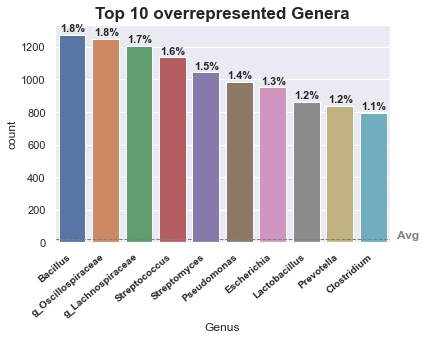

In [32]:
# top 10 Genus and its frequency in a bar chart 
ax = sns.countplot(x='Genus', data=df_full, order=df_full.Genus.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Genera', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(genus_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, genus_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full.Genus))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+20), size = 11, weight='bold')

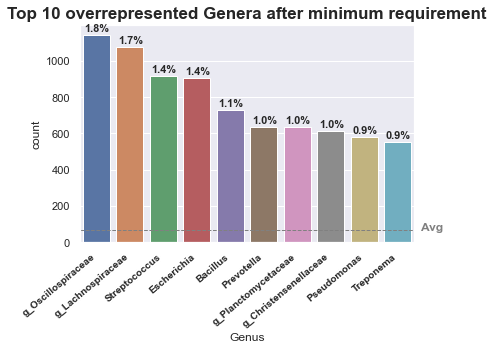

In [34]:
# top 10 Genus and its frequency in a bar chart 
ax = sns.countplot(x='Genus', data=df_full_min_max_rc, order=df_full_min_max_rc.Genus.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Genera after minimum requirement', fontsize=17, weight='bold')
                                                                                                                                                          
# add a horizontal grey line for average count
ax.axhline(genus_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, genus_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full_min_max_rc.Genus))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+20), size = 11, weight='bold')

At genus level, it is clear that over-representation becomes less problematic, as the most over-represented genus is 1.78% of the entire dataset, having about 1,100 entries while average count is 67.

It also becomes clear that the augmentation steps (adding minimum and maximum requirements and reverse complement sequences) have a positive effect on normalizing the dataset.

### 6. Species

In [35]:
# species % representation dataframe with average
species_df = pd.DataFrame(df_full.Species.value_counts().reset_index().values, columns=["Species", "Count"])
species_df['Represented %'] = species_df['Count']/species_df['Count'].sum() * 100
species_df['Represented %'] = species_df['Represented %'].astype(float).round(2)
species_count_df = species_df.set_index('Species')

# calculate average count and average represented percentage for the entire column - label count of species
species_avg = species_df['Count'].mean().astype(int).round(0)
species_avg_pct = species_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with species dataframe 
species_avg = pd.DataFrame({'Species':['AVERAGE'], 'Count':[species_avg], 'Represented %':[species_avg_pct]})
frames = [species_avg, species_df]
species_df_with_avg = pd.concat(frames)

# show first 10 labels in species including average count value for species
species_df_with_avg.set_index('Species').head(10)

,Count,Represented %
Species,,
AVERAGE,3,0.00
g_Oscillospiraceae sp,1238,1.75
g_Lachnospiraceae sp,1165,1.65
Escherichia coli,917,1.30
g_Planctomycetaceae sp,704,0.99
g_Christensenellaceae sp,666,0.94
Treponema sp,544,0.77
g_Rhodospirillaceae sp,506,0.71
Prevotella sp,492,0.70


In [37]:
#--------After minimum requirement--------
# species % representation dataframe with average
species_df = pd.DataFrame(df_full_min_max_rc.Species.value_counts().reset_index().values, columns=["Species", "Count"])
species_df['Represented %'] = species_df['Count']/species_df['Count'].sum() * 100
species_df['Represented %'] = species_df['Represented %'].astype(float).round(2)
species_count_df = species_df.set_index('Species')

# calculate average count and average represented percentage for the entire column - label count of species
species_avg = species_df['Count'].mean().astype(int).round(0)
species_avg_pct = species_df['Represented %'].mean().astype(float).round(2)

# separate average dataframe is created to be concatenated with species dataframe 
species_avg = pd.DataFrame({'Species':['AVERAGE'], 'Count':[species_avg], 'Represented %':[species_avg_pct]})
frames = [species_avg, species_df]
species_df_with_avg = pd.concat(frames)

# show first 10 labels in species including average count value for species
species_df_with_avg.set_index('Species').head(10)

,Count,Represented %
Species,,
AVERAGE,44,0.07
g_Oscillospiraceae sp,1141,1.78
g_Lachnospiraceae sp,1077,1.68
Escherichia coli,904,1.41
g_Planctomycetaceae sp,635,0.99
g_Christensenellaceae sp,614,0.96
Treponema sp,521,0.81
g_Rhodospirillaceae sp,483,0.76
Prevotella sp,442,0.69


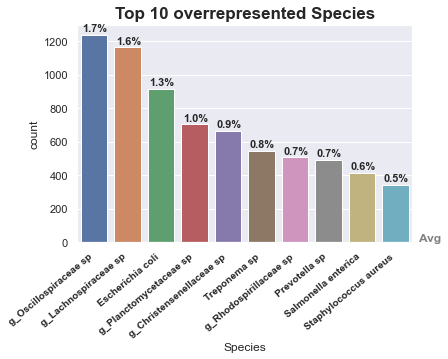

In [36]:
# top 10 Species and its frequency in a bar chart 
ax = sns.countplot(x='Species', data=df_full, order=df_full.Species.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Species', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(species_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, species_avg['Count'], 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full.Species))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+20), size = 11, weight='bold')

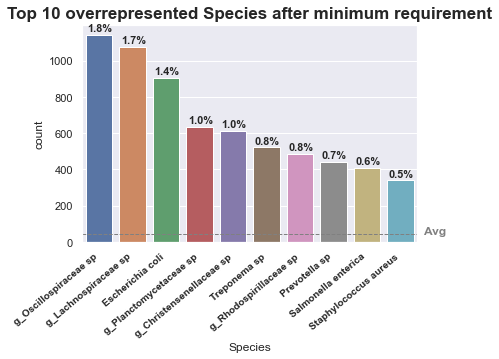

In [38]:
# top 10 Species and its frequency in a bar chart 
ax = sns.countplot(x='Species', data=df_full_min_max_rc, order=df_full_min_max_rc.Species.value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10, weight='bold')
ax.set_title('Top 10 overrepresented Species after minimum requirement', fontsize=17, weight='bold')

# add a horizontal grey line for average count
ax.axhline(species_avg['Count'].item(), ls='--', c='grey', linewidth=1)
ax.text(9.7, species_avg['Count'].item(), 'Avg', weight='bold', c='grey')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_full_min_max_rc.Species))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x-0.3, y+20), size = 11, weight='bold')

For the species level, unsurprisingly, E. coli is the most over-represented (labelled) species in the dataset, which has around 1,000 counts. 

As shown in the full_df dataframe count, the most underrepresented labels only have 1 entry, causing problems in the classification task while spliting the dataset into train, validation and test for machine learning models. However, through a minimum number of entry requirement, the most under-represented label contains 10 counts, ensuring a sufficient number of entries for the data split. This validates the implementation of the minimum requirement on the final dataset, allowing to facilitate data separation.

## Data seperation

After generating the desired datasets and visualizing their properties, the data is split into a training-, validation- and test-set to be fed into the machine/deep learning models.


In order to maintain the proportions of taxons and minimize the likelihood of a taxon being absent in one of the datasets, a stratification seperation is implemented.

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

def df_strat_split(df_input, stratify_colname='Species', frac_train=0.6, frac_val=0.2, frac_test=0.2, random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test) following fractional ratios provided by the user, 
    where each subset is stratified by the values in a specific column 
    (that is, each subset has the same relative frequency of the values in the column). 
    It performs this splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and test data. (float fractions and sum = 1.0)
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split(). 
        (simply sets a seed to the random generator, so that your train-test splits are always deterministic)

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, stratify=y_temp, test_size=relative_frac_test, random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

### Putting it all together - For the training process

What follows is a script to generate and save the desired split datasets.

The data is split beforehand so that the different models can be trained, validated and tested with the same datasets.

In order to maintain the original data structures for the test set, seperation is performed before major data augmentations ((high minimum requirements,) maximum requirements and reverse complement sequences).

In [69]:
# -------------------------------------------------------------------------------------------------------------
# Loading the dataset as a pandas data frame ------------------------------------------------------------------
df = pd.read_csv('full_curated_dataset.csv')
print(f"dataset loaded, shape: {df.shape}")

# -------------------------------------------------------------------------------------------------------------
# Labeling empty cells with an informative value --------------------------------------------------------------
df_empty_filled = empty_fill(df)

# -------------------------------------------------------------------------------------------------------------
# Standardizing the species columns ---------------------------------------------------------------------------
not_sub_df = df_empty_filled[df_empty_filled['Species'].str.contains(' ')]
sub_df = df_empty_filled[~df_empty_filled['Species'].str.contains(' ')]
#       edit species entry for species entry without genus information
sub_df['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']
#       concatenate divided dataframes
frames = [not_sub_df, sub_df]
df_full = pd.concat(frames)
print(f"dataset filled and standardized, shape: {df_full.shape}")

# -------------------------------------------------------------------------------------------------------------
# Removal of highly underrepresented entries ------------------------------------------------------------------
df_full_min = min_entries(df_full, min=5)

# -------------------------------------------------------------------------------------------------------------
# Add sequence ID ---------------------------------------------------------------------------------------------
df_full_min_id = add_SeqID(df_full_min)

# -------------------------------------------------------------------------------------------------------------
# Splitting and saving the data -------------------------------------------------------------------------------
df_train_0, df_val_0, df_test_0 = df_strat_split(df_full_min_id)
df_train_0.to_csv('df_train_0.csv', index=False)
df_val_0.to_csv('df_val_0.csv', index=False)
df_test_0.to_csv('df_test_0.csv', index=False)
print(f"train/val/test split and save complemented\n{df_train_0.shape} - {df_val_0.shape} - {df_test_0.shape}")

# -------------------------------------------------------------------------------------------------------------
# Tackle overrepresentation with nucleotide ambiguity ---------------------------------------------------------
df_train_full_max = remove_over_repr_ambiguous(df_train_0)
df_val_full_max = remove_over_repr_ambiguous(df_val_0)
print(f"train/val datasets un-overrepresented\n{df_train_full_max.shape} - {df_val_full_max.shape}")

# -------------------------------------------------------------------------------------------------------------
# Increase the amount of entries by adding the reverse complement sequences -----------------------------------
rc_df_train = representative_rc(df_train_full_max)
rc_df_val = representative_rc(df_val_full_max)
df_train_full_max_rc = pd.concat([df_train_full_max, rc_df_train], ignore_index=True)
df_val_full_max_rc = pd.concat([df_val_full_max, rc_df_val], ignore_index=True)
print(f"train/val datasets reverse complemented\n{df_train_full_max_rc.shape} - {df_val_full_max_rc.shape}")

# -------------------------------------------------------------------------------------------------------------
# Tackle underrepresentation by setting a minimum number of entries -------------------------------------------
# df_train_full_min_max_rc = min_entries(df_train_full_max_rc, min=10)
# df_val_full_min_max_rc = min_entries(df_val_full_max_rc, min=10)
# print(f"train/val datasets un-underrepresented\n{df_train_full_min_max_rc.shape} - {df_val_full_min_max_rc.shape}")

# Running this extra minimal-entry-restriction caused the number of unique labels in the train/val/test 
# datasets to be unequal. An equal number of classes per dataset is required to run the deep-learning models.

# -------------------------------------------------------------------------------------------------------------
# Save train/val datasets -------------------------------------------------------------------------------------
df_train_full_max_rc.to_csv('df_train_1.csv', index=False)
df_val_full_max_rc.to_csv('df_val_1.csv', index=False)
print(f"augmented train/val datasets saved\n{df_train_full_max_rc.shape} - {df_val_full_max_rc.shape}")

dataset loaded, shape: (70785, 8)
dataset filled and standardized, shape: (70785, 8)


C:\Users\robbe\AppData\Local\Temp/ipykernel_8696/153162575.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']


train/val/test split and save complemented
(26862, 9) - (8954, 9) - (8954, 9)
train/val datasets un-overrepresented
(26147, 9) - (8849, 9)


C:\Users\robbe\AppData\Local\Temp/ipykernel_8696/4038198815.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sequence'] = df['Sequence'].apply(lambda row : reverse_complement(row))


train/val datasets reverse complemented
(39284, 9) - (13213, 9)
augmented train/val datasets saved
(39284, 9) - (13213, 9)


In [72]:
# number of unique labels at family level for the 3 datasets before augmentation
print(df_train_0['Family'].nunique(), df_val_0['Family'].nunique(), df_test_0['Family'].nunique())

349 349 349


In [73]:
# number of unique labels at family level for the 3 datasets after augmentation
print(df_train_full_max_rc['Family'].nunique(), df_val_full_max_rc['Family'].nunique(), df_test_0['Family'].nunique())

349 349 349


In [74]:
# number of unique labels at genus level for the 3 datasets before augmentation
print(df_train_0['Genus'].nunique(), df_val_0['Genus'].nunique(), df_test_0['Genus'].nunique())

954 954 954


In [75]:
# number of unique labels at genus level for the 3 datasets after augmentation
print(df_train_full_max_rc['Genus'].nunique(), df_val_full_max_rc['Genus'].nunique(), df_test_0['Genus'].nunique())

954 954 954


In [76]:
# number of unique labels at species level for the 3 datasets before augmentation
print(df_train_0['Species'].nunique(), df_val_0['Species'].nunique(), df_test_0['Species'].nunique())

1573 1573 1573


In [77]:
# number of unique labels at genus level for the 3 datasets after augmentation
print(df_train_full_max_rc['Species'].nunique(), df_val_full_max_rc['Species'].nunique(), df_test_0['Species'].nunique())

1573 1573 1573
